# Libraries

In [190]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2,ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, LSTM, Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [191]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# Data

### Load and Transform Data

In [192]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [193]:
base_dir = r"C:\Users\user\Documents\Datasets\Cat_Breed"

### Count data and Classes

number of classes in Base directory folder : 11


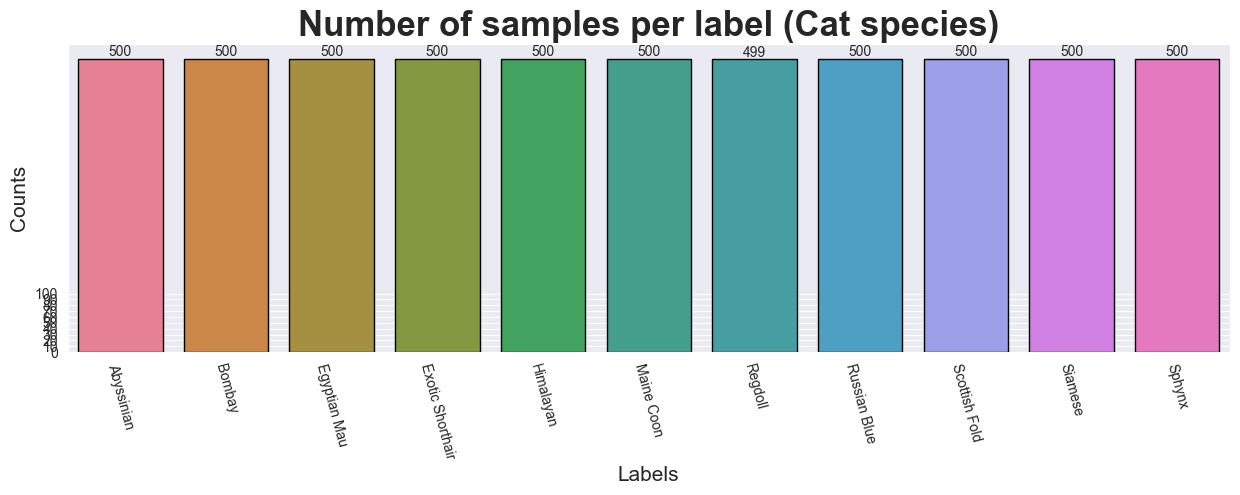

In [194]:
def num_of_classes(folder_dir, folder_name):
    classes = [class_name for class_name in os.listdir(base_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'green', attrs=['bold']))
num_of_classes(base_dir, 'Base directory')

classes = [class_name for class_name in os.listdir(base_dir)]
count = []

for class_name in classes:
    count.append(len(os.listdir(os.path.join(base_dir, class_name))))
    
plt.figure(figsize = (15, 4))
ax = sns.barplot(x = classes, y = count, hue = classes, edgecolor = 'black')
plt.xticks(rotation = 285)
for i in ax.containers:
    ax.bar_label(i, )
plt.title('Number of samples per label (Cat species)', fontsize = 25, fontweight = 'bold')
plt.xlabel('Labels', fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

### Converting data into Dataframe

In [195]:
def create_df(folder_path):
    all_images = []
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

dataset = create_df(base_dir)

#Making Training, Test, and validation dataset
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=0)
val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, random_state=0)

print(colored(f'Number of samples in training dataset: {len(train_dataset)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in test dataset: {len(test_dataset)}', 'green', attrs=['bold']))
print(colored(f'Number of samples in validation dataset: {len(val_dataset)}', 'red', attrs=['bold']))

Number of samples in training dataset: 4399
Number of samples in test dataset: 550
Number of samples in validation dataset: 550


## Show images per class label

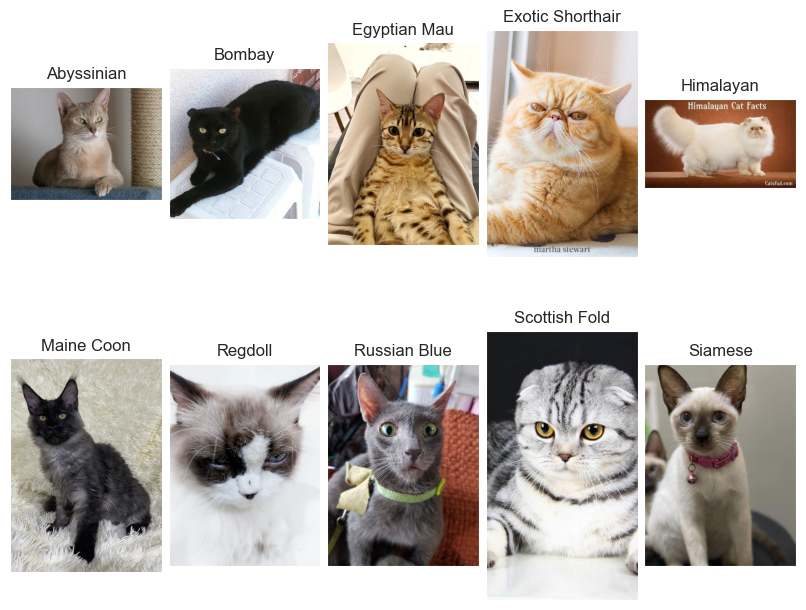

In [196]:
df_unique = dataset.copy().drop_duplicates(subset=['label']).reset_index()

fig, axes = plt.subplots(2, 5, figsize = (8, 7),
                        subplot_kw= {'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

## Data Generator

Train Generator

In [197]:
# Train generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    shear_range = 0.1,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_dataset,
    x_col = 'file_path',
    y_col = 'label',
    target_size = TARGET_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42
)

Found 4399 validated image filenames belonging to 11 classes.


Validation generator

In [198]:
# Validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = val_dataset,
    x_col = 'file_path',
    y_col = 'label',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    seed = 42,
    shuffle = False
)

Found 550 validated image filenames belonging to 11 classes.


Test generator

In [199]:
test_datagen = ImageDataGenerator(rescale=1. / 255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_dataset,
    x_col = 'file_path',
    y_col = 'label',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32,
    seed = 42,
    shuffle = False
)

Found 550 validated image filenames belonging to 11 classes.


# Modeling

## Building Model

In [200]:
pre_trained_model = ResNet50(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

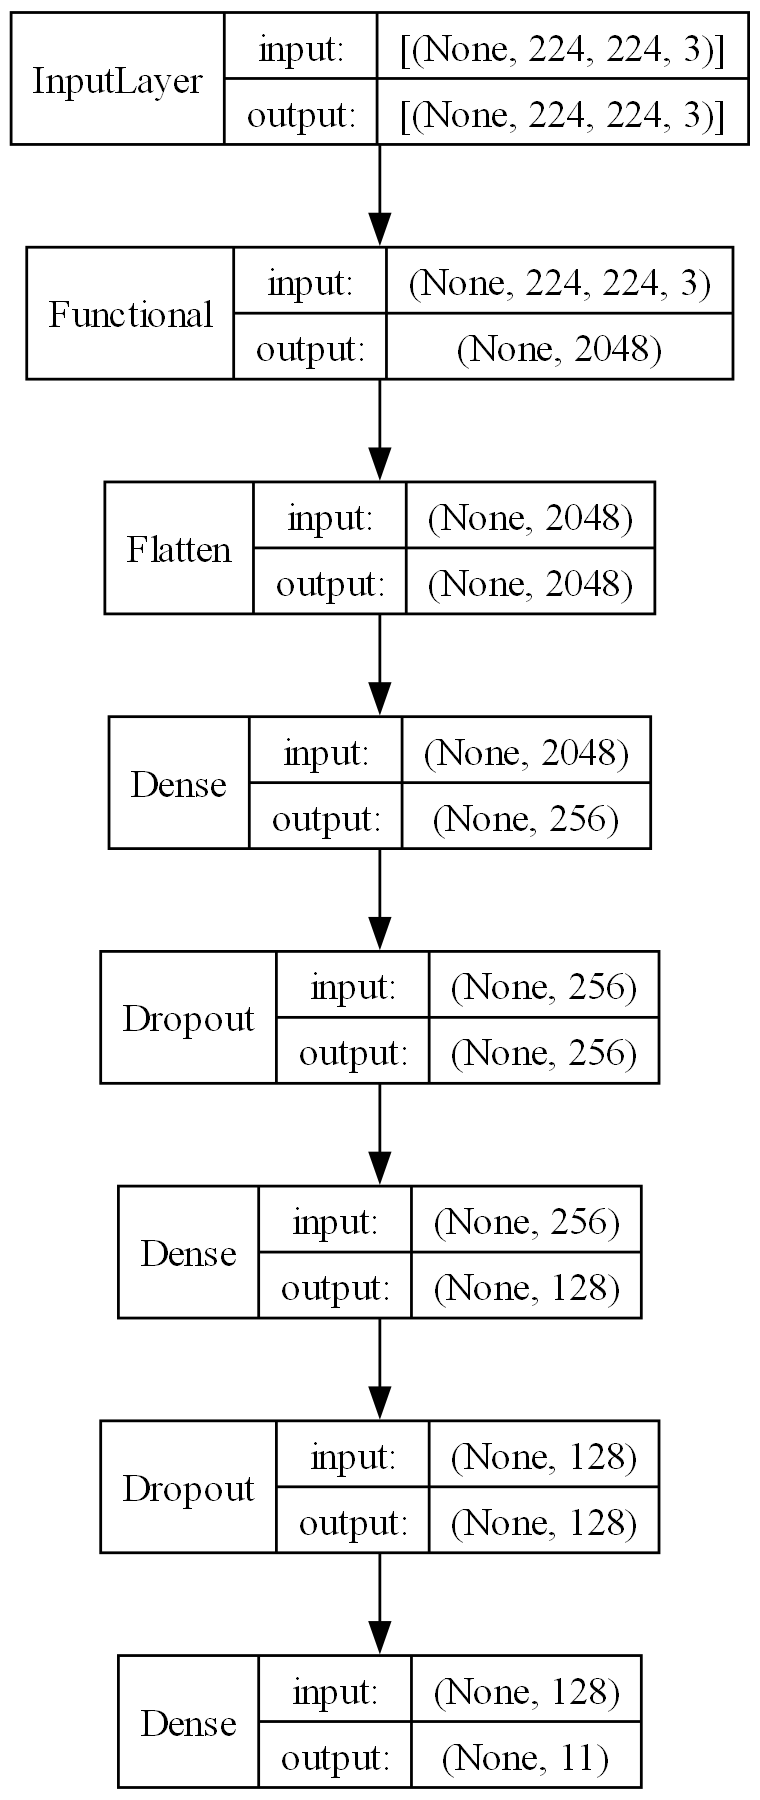

In [201]:
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(11, activation = 'softmax'))
plot_model(model, show_shapes=True, show_layer_names=False, dpi = 200)

In [202]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_15 (Flatten)        (None, 2048)              0         
                                                                 
 dense_37 (Dense)            (None, 256)               524544    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 11)              

## Compile Model

In [203]:
model.compile(optimizer = optimizers.Adam(learning_rate=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

## Callbacks

In [204]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stopping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-6)

## Training

In [205]:
history = model.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs = 50,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/50
138/138 [==============================] - 79s 527ms/step - loss: 1.6409 - accuracy: 0.4844 - val_loss: 5.6234 - val_accuracy: 0.0836 - lr: 0.0010
Epoch 2/50
138/138 [==============================] - 73s 528ms/step - loss: 1.0236 - accuracy: 0.6758 - val_loss: 2.5098 - val_accuracy: 0.0836 - lr: 0.0010
Epoch 3/50
138/138 [==============================] - 73s 527ms/step - loss: 0.8345 - accuracy: 0.7338 - val_loss: 2.8086 - val_accuracy: 0.0945 - lr: 0.0010
Epoch 4/50
138/138 [==============================] - 72s 517ms/step - loss: 0.6652 - accuracy: 0.7972 - val_loss: 2.7953 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 5/50
138/138 [==============================] - 73s 530ms/step - loss: 0.5570 - accuracy: 0.8320 - val_loss: 2.2156 - val_accuracy: 0.2145 - lr: 0.0010
Epoch 6/50
138/138 [==============================] - 72s 518ms/step - loss: 0.5050 - accuracy: 0.8438 - val_loss: 2.3586 - val_accuracy: 0.2291 - lr: 0.0010
Epoch 7/50
138/138 [==============================] 

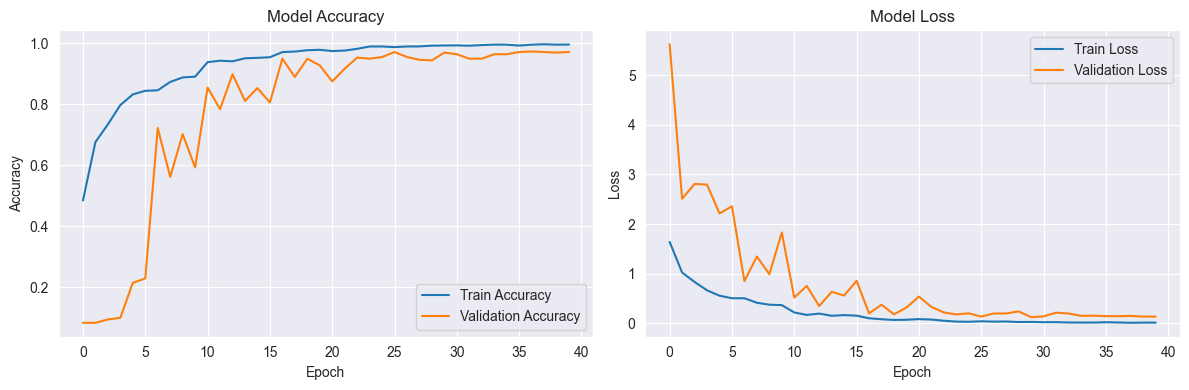

In [206]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

18/18 [==============================] - 5s 279ms/step


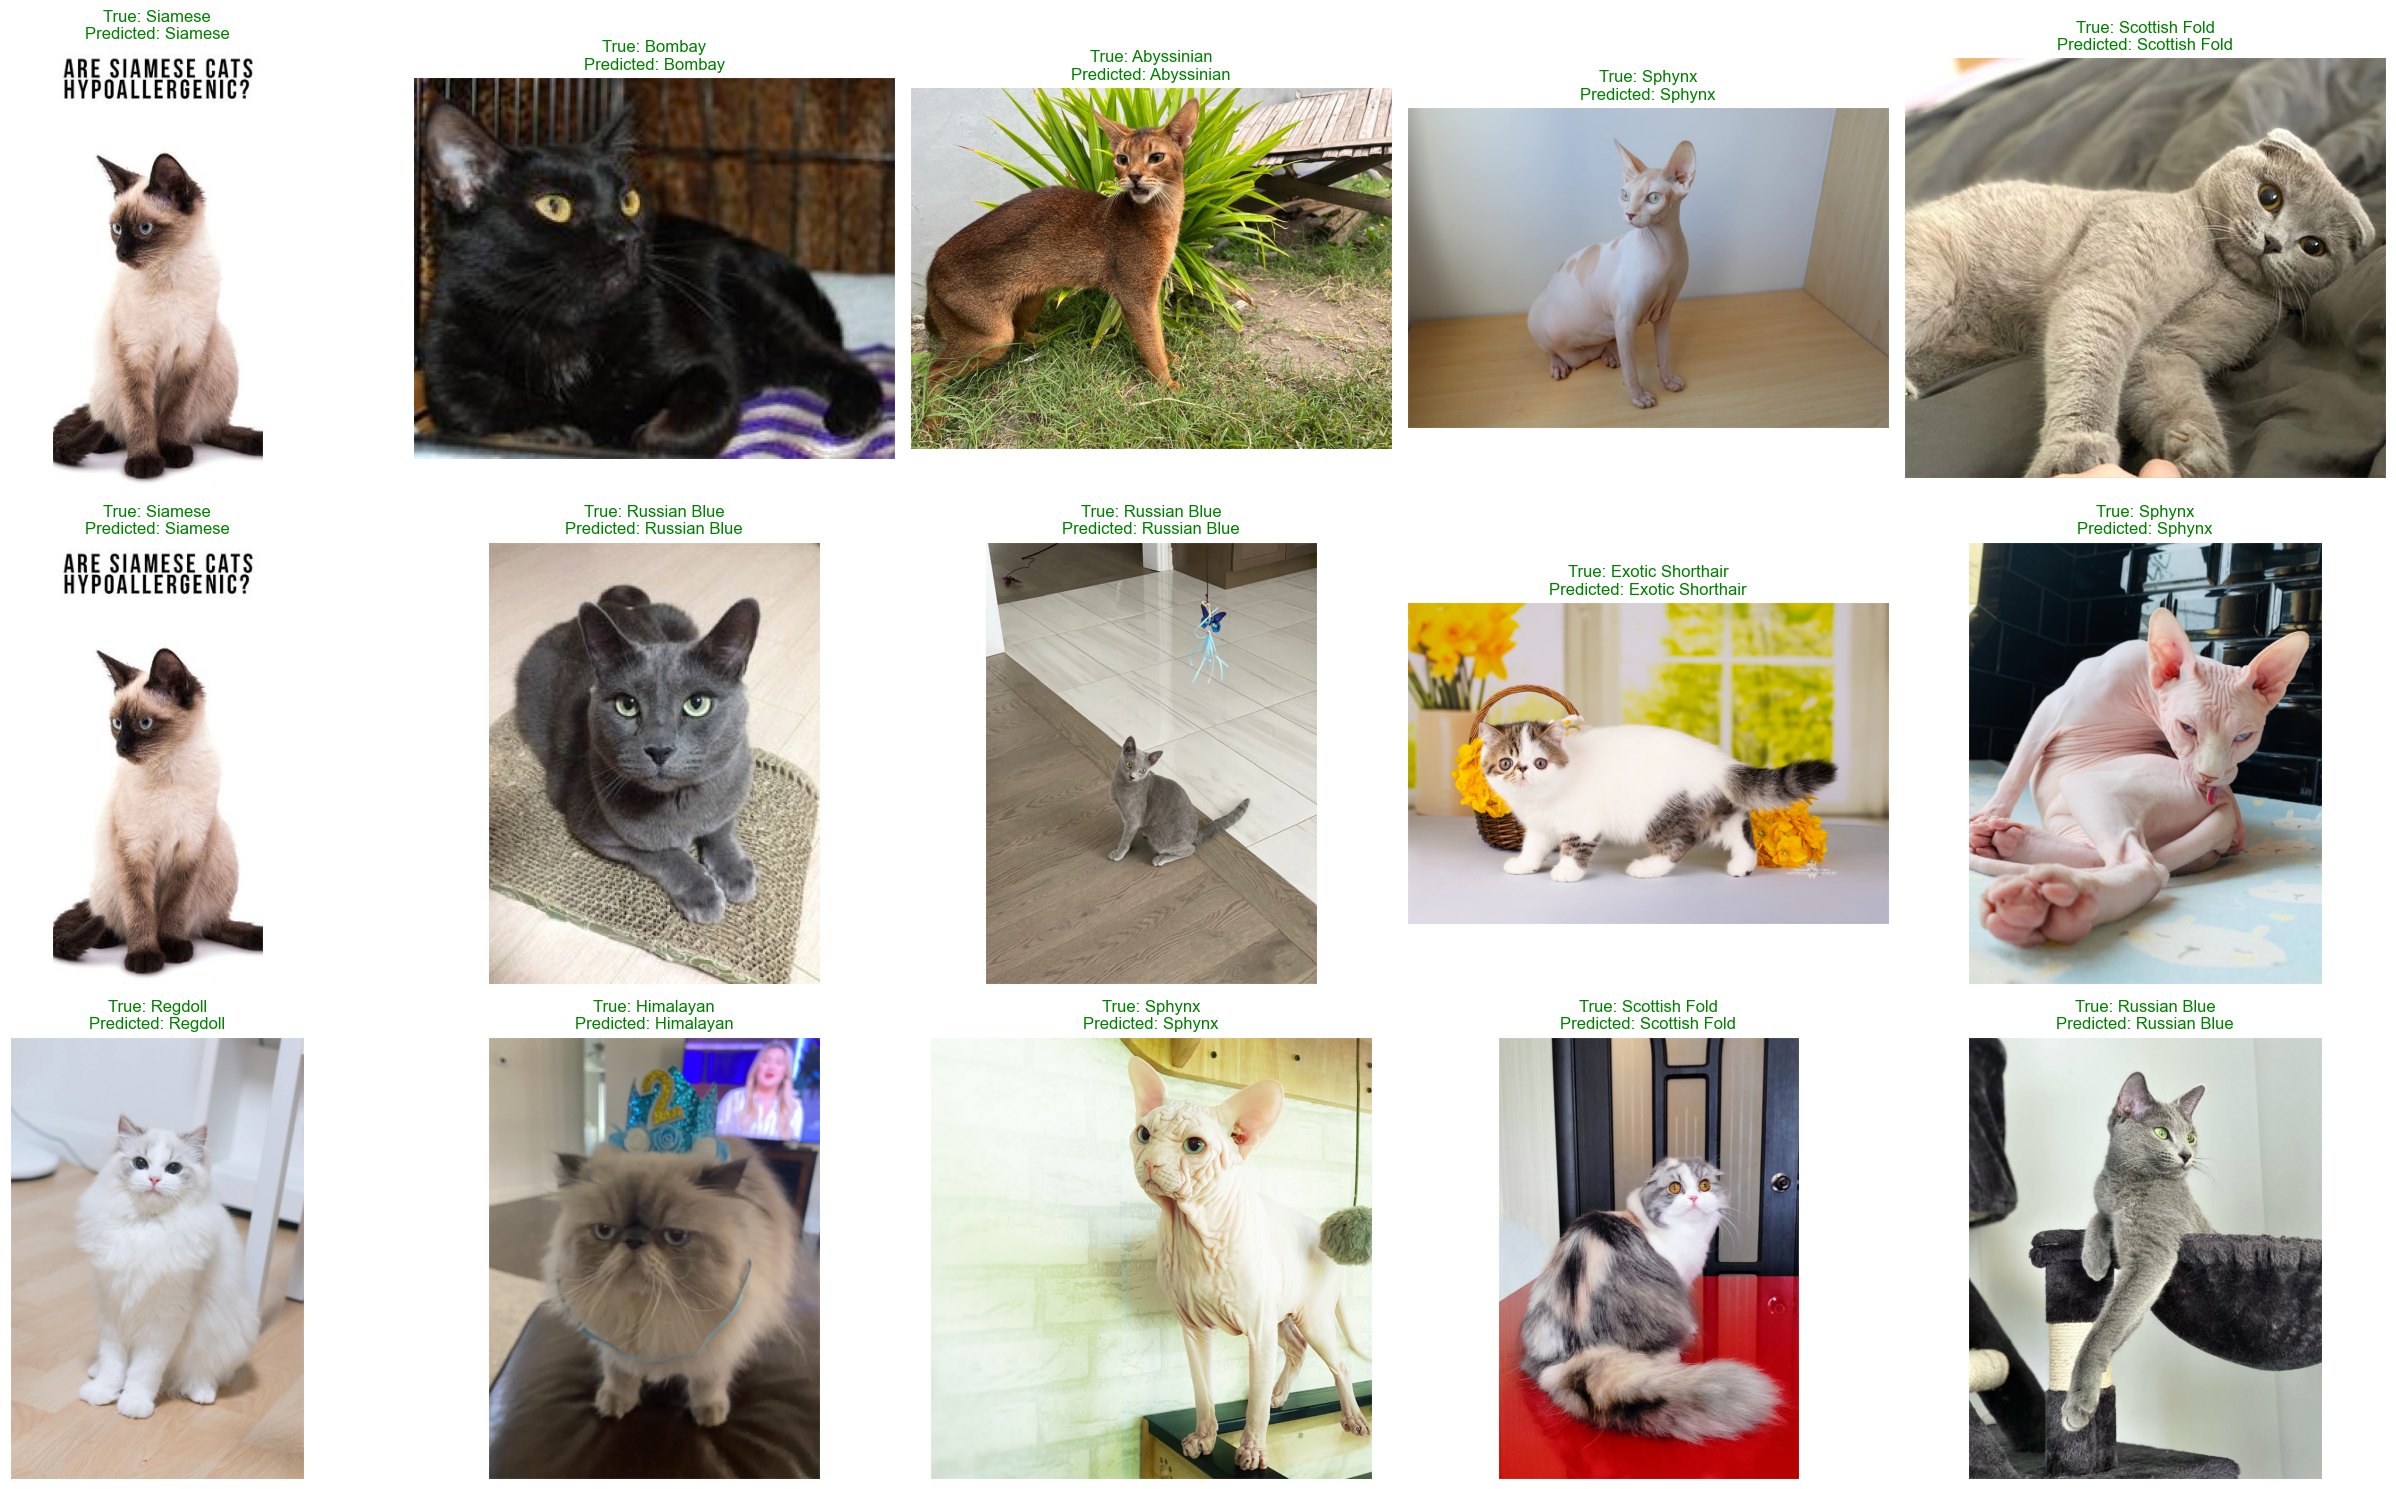

In [209]:
num_images = len(test_dataset)  # Assuming `test_dataset` is a pandas DataFrame with the test data

class_labels = list(validation_generator.class_indices.keys())

# Getting all the true labels for the validation set
true_labels = test_generator.classes

# To get the predicted labels, we predict using the model  
predictions = model.predict(test_generator, steps=len(test_generator))

# Take the argmax to get the predicted class indices.
predicted_labels = np.argmax(predictions, axis=1)

random_index = np.random.randint(0, len(test_dataset) - 1, num_images)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                             subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
        # Replace 'file_path' and 'class_label' with the correct column names for image paths and labels
        img_path = test_dataset['file_path'].iloc[random_index[i]]
        true_label = test_dataset['label'].iloc[random_index[i]]
        
        # Get the predicted class index and map it to the class name
        pred_index = predicted_labels[random_index[i]]
        pred_label = class_labels[pred_index]  # Convert the index to the class name

        # Display the image
        ax.imshow(plt.imread(img_path))
        
        # Determine the color of the title based on prediction accuracy
        if true_label == pred_label:
            color = "green"
        else:
            color = "red"
        
        # Set title showing true and predicted class names
        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color=color)
    
plt.tight_layout()
plt.show()

In [210]:
model.save('cat_breed.h5')